This is a notebook to generate mel-spectrograms from a TTS model to be used for WaveRNN training.
TTS_PATH = "/home/ricktjwong/"

In [1]:
%load_ext autoreload
%autoreload 2
TTS_PATH = "/home/ricktjwong/"
import os
import sys
sys.path.append(TTS_PATH)
import torch
import importlib
import numpy as np
from tqdm import tqdm as tqdm
from torch.utils.data import DataLoader
from TTS.datasets.TTSDataset import MyDataset
from TTS.layers.losses import L1LossMasked
from TTS.utils.audio import AudioProcessor
from TTS.utils.visual import plot_spectrogram
from TTS.utils.generic_utils import setup_model, sequence_mask
from TTS.utils.io import (save_best_model, save_checkpoint,
                          load_config, copy_config_file)
from TTS.utils.text.symbols import make_symbols, symbols, phonemes

%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

/opt/conda/envs/fastdub/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/opt/conda/envs/fastdub/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
def set_filename(wav_path, out_path):
    wav_file = os.path.basename(wav_path)
    file_name = wav_file.split('.')[0]
    os.makedirs(os.path.join(out_path, "quant"), exist_ok=True)
    os.makedirs(os.path.join(out_path, "mel"), exist_ok=True)
    os.makedirs(os.path.join(out_path, "wav_gl"), exist_ok=True)
    wavq_path = os.path.join(out_path, "quant", file_name)
    mel_path = os.path.join(out_path, "mel", file_name)
    wav_path = os.path.join(out_path, "wav_gl", file_name)
    return file_name, wavq_path, mel_path, wav_path

In [4]:
OUT_PATH = "/home/ricktjwong/melspec_020620"
DATA_PATH = "/home/ricktjwong/Clean_16khz/"
DATASET = "tweb"
METADATA_FILE = "/home/ricktjwong/Clean_16khz/transcript.txt"
MODEL_FILE = "/home/ricktjwong/model_outputs/sw-tweb-seqnorm-false-May-31-2020_05+47AM-0000000/best_model_50k+.pth.tar"
CONFIG_PATH = "/home/ricktjwong/TTS/config.json"
VOCODER_CONFIG_PATH = "/home/ricktjwong/neural_vocoder/WaveRNN_config_16K_original.json"

QUANTIZED_WAV = False
QUANTIZE_BIT = 9
DRY_RUN = False   # if False, does not generate output files, only computes loss and visuals.
BATCH_SIZE = 32

use_cuda = torch.cuda.is_available()
print(" > CUDA enabled: ", use_cuda)

C = load_config(CONFIG_PATH)
C.audio['do_trim_silence'] = False  # IMPORTANT!!!!!!!!!!!!!!! disable to align mel specs with the wav files
ap = AudioProcessor(bits=QUANTIZE_BIT, **C.audio)

 > CUDA enabled:  True
 > Setting up Audio Processor...
 | > sample_rate:16000
 | > num_mels:80
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > num_freq:1025
 | > power:1.5
 | > preemphasis:0.98
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:False
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > max_norm:1.0
 | > clip_norm:True
 | > do_trim_silence:False
 | > trim_db:60
 | > do_sound_norm:False
 | > stats_path:None
 | > hop_length:200
 | > win_length:800
 | > n_fft:2048


In [7]:
# if the vocabulary was passed, replace the default
if 'characters' in C.keys():
    symbols, phonemes = make_symbols(**C.characters)

# load the model
num_chars = len(phonemes) if C.use_phonemes else len(symbols)
# TODO: multiple speaker
model = setup_model(num_chars, num_speakers=0, c=C)
checkpoint = torch.load(MODEL_FILE)
model.load_state_dict(checkpoint['model'])
print(checkpoint['step'])
model.eval()
model.decoder.set_r(checkpoint['r'])
if use_cuda:
    model = model.cuda()

 > Using model: Tacotron2
58165


In [8]:
preprocessor = importlib.import_module('TTS.datasets.preprocess')
preprocessor = getattr(preprocessor, DATASET.lower())
meta_data = preprocessor(DATA_PATH, METADATA_FILE)
dataset = MyDataset(checkpoint['r'], C.text_cleaner, False,
                    ap, meta_data, tp=C.characters if 'characters' in C.keys() else None,
                    use_phonemes=C.use_phonemes,  phoneme_cache_path=C.phoneme_cache_path,
                    enable_eos_bos=C.enable_eos_bos_chars,
                    batch_group_size=0, min_seq_len=6, max_seq_len=150, phoneme_language="sw")
# dataset = MyDataset(outputs_per_step=2, text_cleaner=C.text_cleaner, 
#                     ap=ap, meta_data=METADATA_FILE, tp=None, 
#                     batch_group_size=0, min_seq_len=6, max_seq_len=200,
#                     use_phonemes=C.use_phonemes, phoneme_cache_path=C.phoneme_cache_path,
#                     phoneme_language="sw")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, collate_fn=dataset.collate_fn, shuffle=False, drop_last=False)

### Generate model outputs 

In [9]:
import pickle

file_idxs = []
metadata = []
losses = []
postnet_losses = []
criterion = L1LossMasked(seq_len_norm=C.seq_len_norm)
with torch.no_grad():
    for data in tqdm(loader):
        # setup input data
        text_input = data[0]
        text_lengths = data[1]
        linear_input = data[3]
        mel_input = data[4]
        mel_lengths = data[5]
        stop_targets = data[6]
        item_idx = data[7]

        # dispatch data to GPU
        if use_cuda:
            text_input = text_input.cuda()
            text_lengths = text_lengths.cuda()
            mel_input = mel_input.cuda()
            mel_lengths = mel_lengths.cuda()

        mask = sequence_mask(text_lengths)
        mel_outputs, postnet_outputs, alignments, stop_tokens = model.forward(text_input, text_lengths, mel_input)
        
        # compute loss
        loss = criterion(mel_outputs, mel_input, mel_lengths)
        loss_postnet = criterion(postnet_outputs, mel_input, mel_lengths)
        losses.append(loss.item())
        postnet_losses.append(loss_postnet.item())

        # compute mel specs from linear spec if model is Tacotron
        if C.model == "Tacotron":
            mel_specs = []
            postnet_outputs = postnet_outputs.data.cpu().numpy()
            for b in range(postnet_outputs.shape[0]):
                postnet_output = postnet_outputs[b]
                mel_specs.append(torch.FloatTensor(ap.out_linear_to_mel(postnet_output.T).T).cuda())
            postnet_outputs = torch.stack(mel_specs)
        elif C.model == "Tacotron2":
            postnet_outputs = postnet_outputs.detach().cpu().numpy()
        alignments = alignments.detach().cpu().numpy()

        if not DRY_RUN:
            for idx in range(text_input.shape[0]):
                wav_file_path = item_idx[idx]
                wav = ap.load_wav(wav_file_path)
                file_name, wavq_path, mel_path, wav_path = set_filename(wav_file_path, OUT_PATH)
                file_idxs.append(file_name)

                # quantize and save wav
                if QUANTIZED_WAV:
                    wavq = ap.quantize(wav)
                    np.save(wavq_path, wavq)

                # save TTS mel
                mel = postnet_outputs[idx]
                mel_length = mel_lengths[idx]
                mel = mel[:mel_length, :].T
                np.save(mel_path, mel)

                metadata.append([wav_file_path, mel_path])

    # for wavernn
    if not DRY_RUN:
        pickle.dump(file_idxs, open(OUT_PATH+"/dataset_ids.pkl", "wb"))      
    
    # for pwgan
    with open(os.path.join(OUT_PATH, "metadata.txt"), "w") as f:
        for data in metadata:
            f.write(f"{data[0]}|{data[1]+'.npy'}\n")

    print(np.mean(losses))
    print(np.mean(postnet_losses))

100%|██████████| 611/611 [1:18:59<00:00,  7.76s/it]

0.0406418785013856
0.037475384899861686


In [10]:
# for pwgan
with open(os.path.join(OUT_PATH, "metadata.txt"), "w") as f:
    for data in metadata:
        f.write(f"{data[0]}|{data[1]+'.npy'}\n")

### Sanity Check

In [11]:
idx = 1
ap.melspectrogram(ap.load_wav(item_idx[idx])).shape

(80, 839)

In [12]:
import soundfile as sf
wav, sr = sf.read(item_idx[idx])
mel_postnet = postnet_outputs[idx][:mel_lengths[idx], :]
mel_decoder = mel_outputs[idx][:mel_lengths[idx], :].detach().cpu().numpy()
mel_truth = ap.melspectrogram(wav)
print(mel_truth.shape)

(80, 839)


(839, 80)


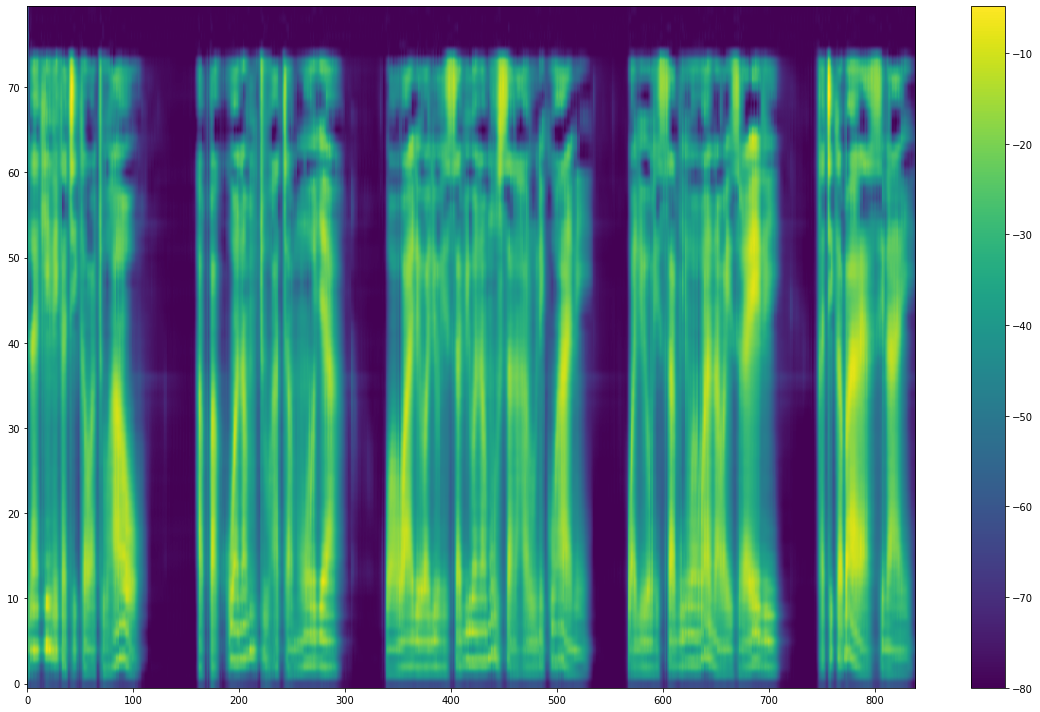

In [13]:
# plot posnet output
plot_spectrogram(mel_postnet, ap);
print(mel_postnet[:mel_lengths[idx], :].shape)

(839, 80)


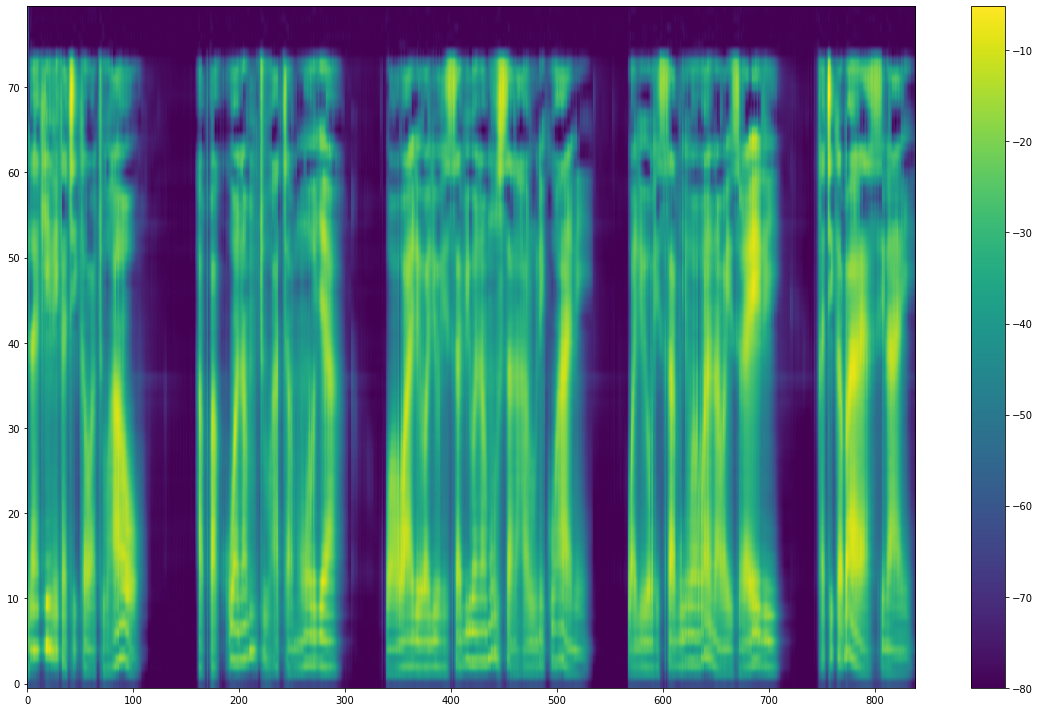

In [14]:
# plot decoder output
plot_spectrogram(mel_decoder, ap);
print(mel_decoder.shape)

(80, 839)


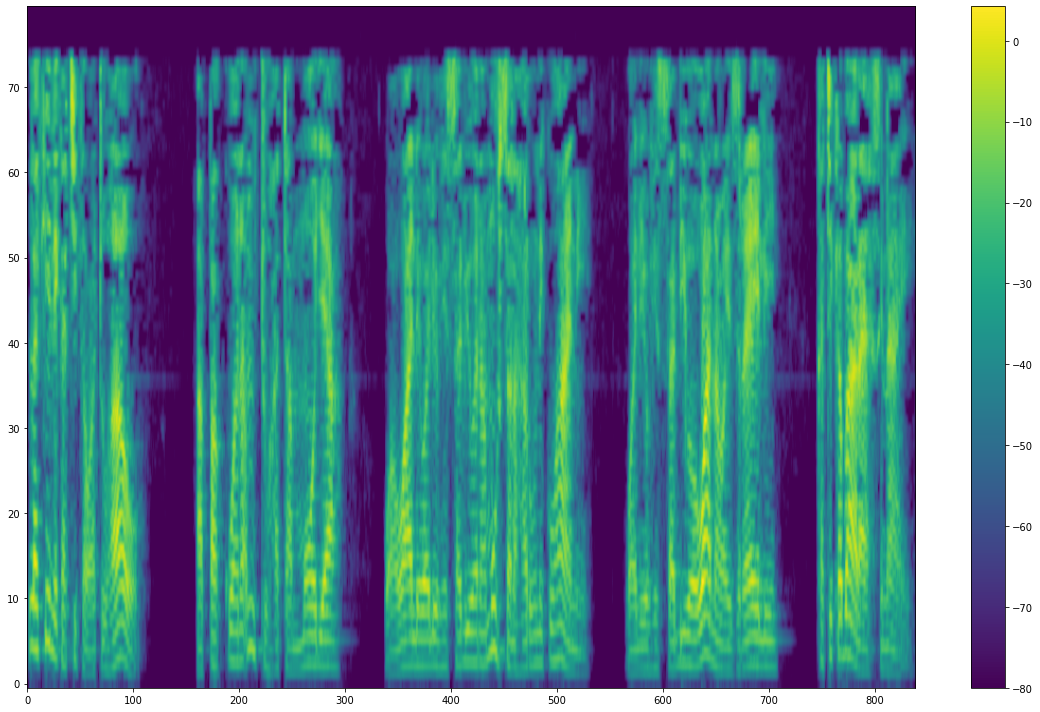

In [15]:
# plot GT specgrogram
print(mel_truth.shape)
plot_spectrogram(mel_truth.T, ap);

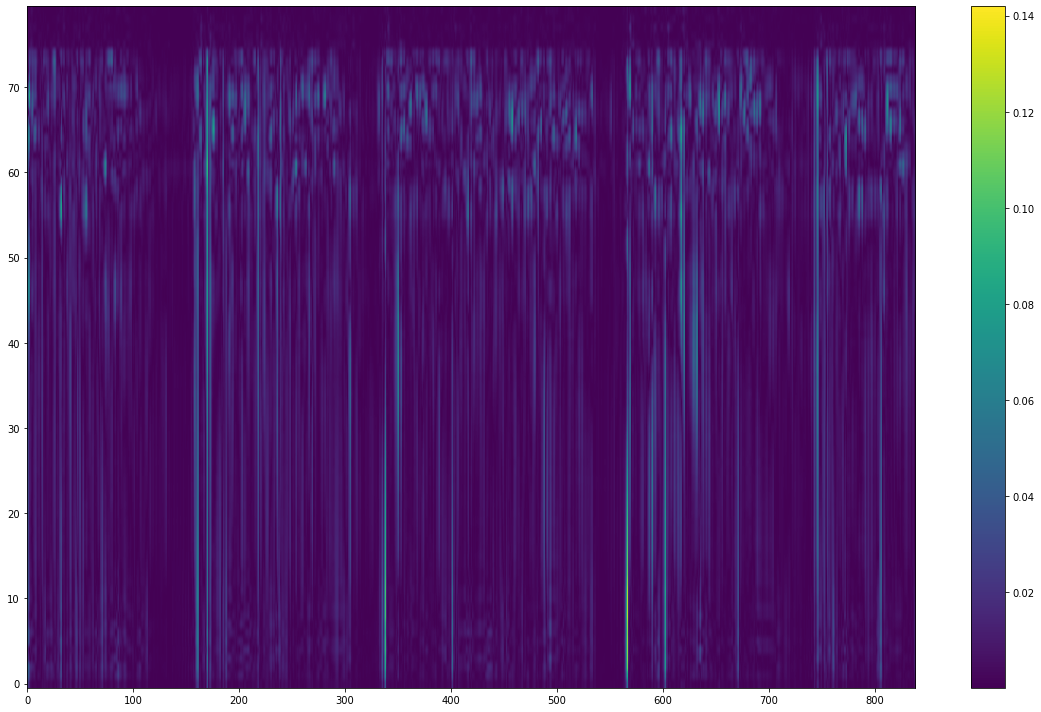

In [16]:
# postnet, decoder diff
from matplotlib import pylab as plt
mel_diff = mel_decoder - mel_postnet
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff[:mel_lengths[idx],:]).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()

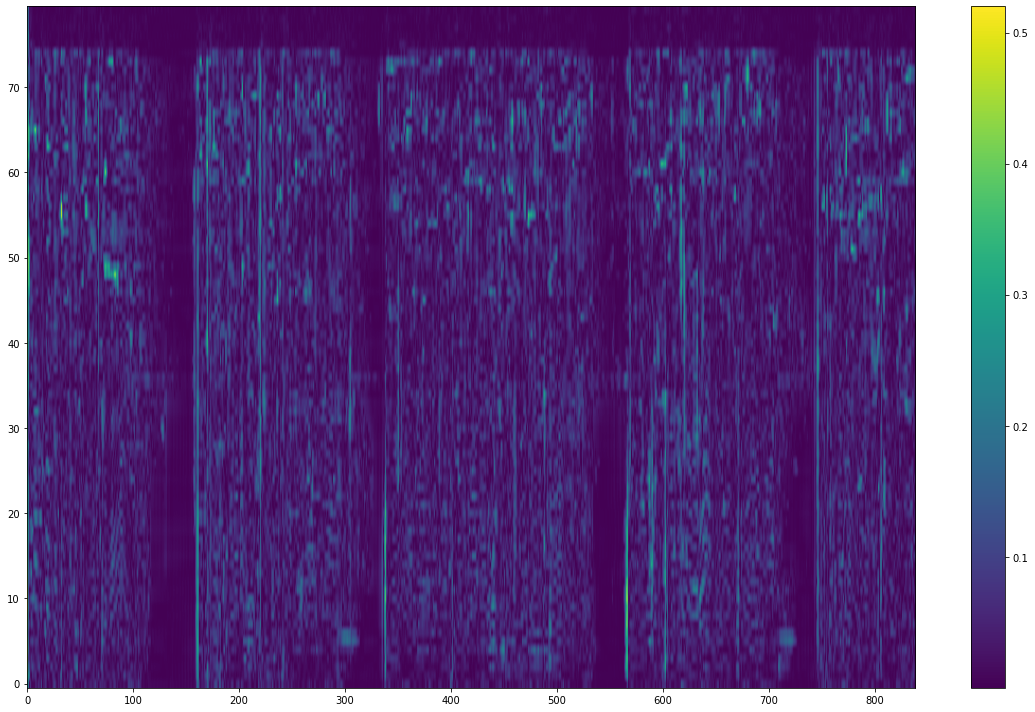

In [17]:
# PLOT GT SPECTROGRAM diff
from matplotlib import pylab as plt
mel_diff2 = mel_truth.T - mel_decoder
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff2).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()

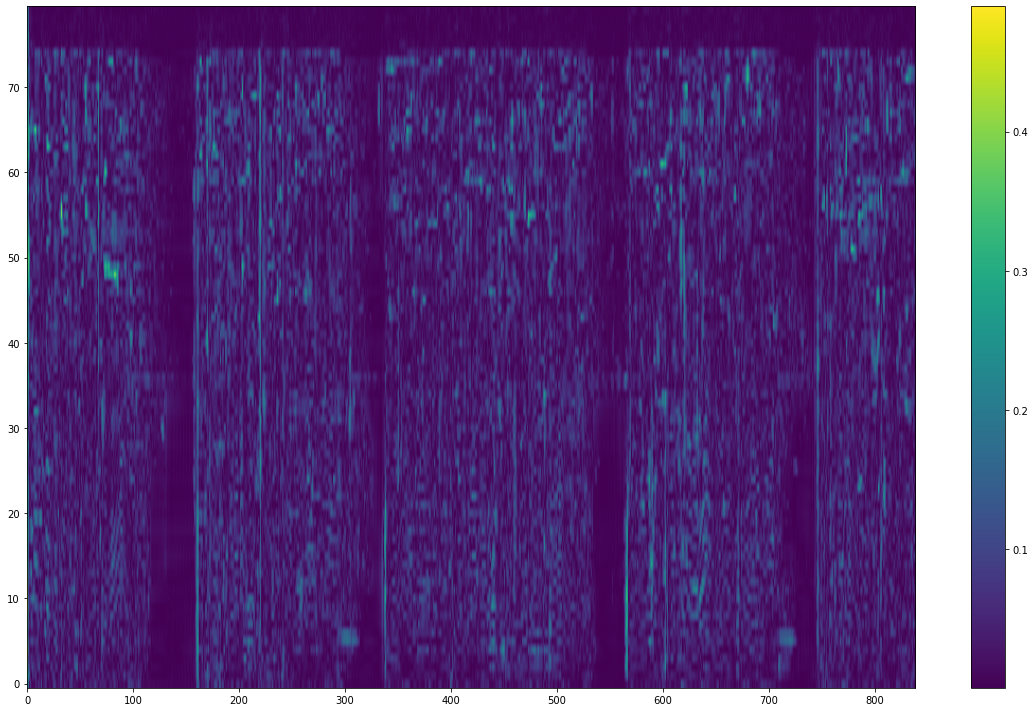

In [18]:
# PLOT GT SPECTROGRAM diff
from matplotlib import pylab as plt
mel = postnet_outputs[idx]
mel_diff2 = mel_truth.T - mel[:mel_truth.shape[1]]
plt.figure(figsize=(16, 10))
plt.imshow(abs(mel_diff2).T,aspect="auto", origin="lower");
plt.colorbar()
plt.tight_layout()